In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import sklearn

from npDoseResponseDR import DRCurve
from npDoseResponseDerivDR import DRDerivCurve, NeurNet
import sys
import pickle

import Supplement

In [2]:
data = pd.read_csv('./job_corps.csv', index_col=0)
data = data.sample(frac=1, random_state=20)

data = pd.concat([data.select_dtypes(exclude='int64'),
                  pd.get_dummies(data.select_dtypes('int64').astype('category'),
                                 drop_first=True).astype('int64')],
                 axis=1)
X = data.drop(['d','y'], axis=1).values #define covariate vector, excluding T and Y
T = data['d'].values # define treatment vector
Y = data['y'].values # define outcome vector

In [3]:
df = pd.read_csv('./job_corps.csv', index_col=0)
df.columns

Index(['y', 'd', 'female', 'age', 'race_white', 'race_black', 'race_hispanic',
       'hgrd', 'hgrdmissdum', 'educ_geddiploma', 'educ_hsdiploma', 'ntv_engl',
       'marstat_divorced', 'marstat_separated', 'marstat_livetogunm',
       'marstat_married', 'haschldY0', 'everwkd', 'mwearn', 'hohhd0',
       'peopleathome', 'peopleathomemissdum', 'nonres', 'work_dad_didnotwork',
       'g7', 'welfare_child', 'welfare_childmissdum', 'h1_fair_poor', 'h2',
       'h10', 'h10missdum', 'h5', 'h5missdum', 'h7', 'h7missdum', 'i1', 'i10',
       'e12', 'e12missdum', 'e16', 'e16missdum', 'e21', 'e30', 'e30missdum',
       'e31', 'e32', 'e35', 'e35missdum', 'e37', 'e6_byphone', 'e9ef'],
      dtype='object')

## Replicate the Setups and Methods in Colangelo and Lee 2020

In [4]:
model_nn1 = Supplement.NeuralNet1_emp_app(k=139,
                                          lr=0.15,
                                          momentum=0.9,
                                          epochs=100,
                                          weight_decay=0.05)

model_nn2 = Supplement.NeuralNet2_emp_app(k=138,
                                          lr=0.05, 
                                          momentum=0.3,
                                          epochs=100,
                                          weight_decay=0.15)

model_knn1 = Supplement.NeuralNet1k_emp_app(k=138,
                                          lr=0.15,
                                          momentum=0.9,
                                          epochs=100,
                                          weight_decay=0.05)

model_knn2 = Supplement.NeuralNet2_emp_app(k=138,
                                          lr=0.05, 
                                          momentum=0.3,
                                          epochs=100,
                                          weight_decay=0.15)

### L=5

In [23]:
# Set of all t we will evaluate at. We start at t=160 as the estimator performs
# poorly at the boundary (in general we recommend to avoid the boundary points).
t_list = np.arange(160, 2001, 40) 
t_list_new = np.arange(40, 4001, 40)
t_list = t_list_new
h = np.std(T)*3*(len(Y)**(-0.2)) # Initial rule of thumb bandwidth choice
# We use both the rule of thumb bandwidth, and double it, as we need to compute
# the estimator at two bandwidths in order to estimate the optimal bandwidth. 
h = 2*h 
L = 5 # Number of folds for cross-fitting
col_names = ['t','beta','se','h_star','h'] # names for everything we store from the estimation
u = 0.5 #Defines the multiple of the previous "h" that is used as a second bandwidth.

ml_list = ['nn','knn'] # ml methods to be used.
# We first iterate over every method, estimating for bandwidth 2*h
# where h is chosen as a rule of thumb bandwidth 3*std(T)*N^(-0.2).
# We use the estimates from these two bandwidth choices and apply
# the optimal bandwidth estimator in Colangelo and Lee (2022) to obtain
# the final optimal bandwidth. The second loop then iterates over all ML
# methods and uses the optimal bandwidth. 
for ml in ml_list:
    if ml == 'knn':
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    else:
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.DDMLCT(model_nn1, model_nn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    
    # We compute h_star based on the formulas from our paper, utilizing output
    # from this first round of estimation.
    Bt = (model.beta-model2.beta)/((model.h**2)*(1-(u**2)))
    h_star = np.mean(((model2.Vt/(4*(Bt**2)))**0.2)*(model.n**-0.2))

    # Combine different outputs we wish to store and save to excel. We do not
    # compute theta_hat here, but in another file later "partial_effects.py"
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path + name
    output.to_excel(file)

In [24]:
L = 5
# Carry out the estimation a second time, this time using the computed h*
for ml in ml_list:
    # First read h_star from the output files of the first round estimation
    path = './Results/'
    name ='emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path+name
    dat = pd.read_excel(file)
    h = dat['h_star'][0]  
    h = (0.8*h)
    
    # Refit models with new h_star
    if ml=='knn':
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    else:
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(model.h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5_hstar.xlsx'
    file = path + name
    output.to_excel(file)

In [25]:
# This function shifts the vector of estimates so we can take differences
# between estimates at two different t's.
def shift(xs, gap):
    e = np.empty_like(xs)
    if gap >= 0:
        e[:gap] = np.nan
        e[gap:] = xs[:-gap]
    else:
        e[gap:] = np.nan
        e[:gap] = xs[-gap:]
    return e

# the first loop computes estimates under optimal bandwidth. The second loop
# computes estimates under rule of thumb bandwidth.
ml_list = ['nn','knn']
gap = 4
eta = 40*gap
for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5_hstar.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])
    dat.to_excel(file,index=False)


for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])

    dat.to_excel(file,index=False)

### L=1

In [40]:
# Set of all t we will evaluate at. We start at t=160 as the estimator performs
# poorly at the boundary (in general we recommend to avoid the boundary points).
t_list = np.arange(160, 2001, 40) 
t_list_new = np.arange(40, 4001, 40)
t_list = t_list_new
h = np.std(T)*3*(len(Y)**(-0.2)) # Initial rule of thumb bandwidth choice
# We use both the rule of thumb bandwidth, and double it, as we need to compute
# the estimator at two bandwidths in order to estimate the optimal bandwidth. 
h = 2*h 
L = 1 # Number of folds for cross-fitting
col_names = ['t','beta','se','h_star','h'] # names for everything we store from the estimation
u = 0.5 #Defines the multiple of the previous "h" that is used as a second bandwidth.

ml_list = ['nn','knn'] # ml methods to be used.
# We first iterate over every method, estimating for bandwidth 2*h
# where h is chosen as a rule of thumb bandwidth 3*std(T)*N^(-0.2).
# We use the estimates from these two bandwidth choices and apply
# the optimal bandwidth estimator in Colangelo and Lee (2022) to obtain
# the final optimal bandwidth. The second loop then iterates over all ML
# methods and uses the optimal bandwidth. 
for ml in ml_list:
    if ml == 'knn':
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    else:
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.DDMLCT(model_nn1, model_nn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    
    # We compute h_star based on the formulas from our paper, utilizing output
    # from this first round of estimation.
    Bt = (model.beta-model2.beta)/((model.h**2)*(1-(u**2)))
    h_star = np.mean(((model2.Vt/(4*(Bt**2)))**0.2)*(model.n**-0.2))

    # Combine different outputs we wish to store and save to excel. We do not
    # compute theta_hat here, but in another file later "partial_effects.py"
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1.xlsx'
    file = path + name
    output.to_excel(file)

In [41]:
L = 1
# Carry out the estimation a second time, this time using the computed h*
for ml in ml_list:
    # First read h_star from the output files of the first round estimation
    path = './Results/'
    name ='emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path+name
    dat = pd.read_excel(file)
    h = dat['h_star'][0]  
    h = (0.8*h)
    
    # Refit models with new h_star
    if ml=='knn':
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    else:
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(model.h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1_hstar.xlsx'
    file = path + name
    output.to_excel(file)

In [42]:
# This function shifts the vector of estimates so we can take differences
# between estimates at two different t's.
def shift(xs, gap):
    e = np.empty_like(xs)
    if gap >= 0:
        e[:gap] = np.nan
        e[gap:] = xs[:-gap]
    else:
        e[gap:] = np.nan
        e[:gap] = xs[-gap:]
    return e

# the first loop computes estimates under optimal bandwidth. The second loop
# computes estimates under rule of thumb bandwidth.
ml_list = ['nn','knn']
gap = 4
eta = 40*gap
for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1_hstar.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])
    dat.to_excel(file,index=False)


for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])

    dat.to_excel(file,index=False)

## Our proposed estimators

In [16]:
# Evaluation points
t_list = np.arange(160, 2001, 40) 
t_list_new = np.arange(40, 4001, 40)

# Standardize the data as in Colangelo and Lee 2020
dat = np.column_stack([Y,T,X])
dat = sklearn.preprocessing.StandardScaler().fit_transform(pd.DataFrame(dat))
Y_new = dat[:,0]
X_dat = dat[:,1:]
t_qry = (t_list_new - np.mean(T))/np.std(T)

In [145]:
lr = 0.1
h1 = 223/np.std(T)

# m_est_dr1, sd_est_dr1 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                             mu=model_nn1, condTS_type='reg', condTS_mod=model_nn2,
#                             tau=0.001, L=1, h=h1, kern="epanechnikov", h_cond=None,
#                             print_bw=False, bnd_cor=False)

# m_est_dr5, sd_est_dr5 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                             mu=model_nn1, condTS_type='reg', condTS_mod=model_nn2,
#                             tau=0.001, L=5, h=h1, kern="epanechnikov", h_cond=None,
#                             print_bw=False, bnd_cor=False)

theta_dr5, theta_sd5 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
                                beta_mod=NeurNet, n_iter=1000, 
                                lr=lr, condTS_type='reg', condTS_mod=model_nn2, 
                                tau=0.001, L=5, h=h1, kern="epanechnikov", 
                                h_cond=None, print_bw=True, bnd_cor=False, delta=0.01)

theta_dr1, theta_sd1 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
                                beta_mod=NeurNet, n_iter=1000, 
                                lr=lr, condTS_type='reg', condTS_mod=model_nn2, 
                                tau=0.001, L=1, h=h1, kern="epanechnikov", 
                                h_cond=None, print_bw=True, bnd_cor=False, delta=0.01)

The current bandwidth for the DR estimator is 0.23190117220237208.

The current bandwidth for the conditional density estimator is 0.21077068409813662.

Epoch [1/1000], Loss: 3.0735
Epoch [2/1000], Loss: 14.1341
Epoch [3/1000], Loss: 1.2964
Epoch [4/1000], Loss: 2.2409
Epoch [5/1000], Loss: 2.4070
Epoch [6/1000], Loss: 2.0288
Epoch [7/1000], Loss: 1.7687
Epoch [8/1000], Loss: 1.4727
Epoch [9/1000], Loss: 1.2638
Epoch [10/1000], Loss: 1.1661
Epoch [11/1000], Loss: 1.1082
Epoch [12/1000], Loss: 1.0558
Epoch [13/1000], Loss: 1.0159
Epoch [14/1000], Loss: 0.9810
Epoch [15/1000], Loss: 0.9490
Epoch [16/1000], Loss: 0.9258
Epoch [17/1000], Loss: 0.9074
Epoch [18/1000], Loss: 0.8898
Epoch [19/1000], Loss: 0.8738
Epoch [20/1000], Loss: 0.8595
Epoch [21/1000], Loss: 0.8465
Epoch [22/1000], Loss: 0.8350
Epoch [23/1000], Loss: 0.8245
Epoch [24/1000], Loss: 0.8144
Epoch [25/1000], Loss: 0.8049
Epoch [26/1000], Loss: 0.7958
Epoch [27/1000], Loss: 0.7871
Epoch [28/1000], Loss: 0.7787
Epoch [29/1000]

Epoch [283/1000], Loss: 0.0338
Epoch [284/1000], Loss: 0.0334
Epoch [285/1000], Loss: 0.0330
Epoch [286/1000], Loss: 0.0326
Epoch [287/1000], Loss: 0.0322
Epoch [288/1000], Loss: 0.0319
Epoch [289/1000], Loss: 0.0315
Epoch [290/1000], Loss: 0.0311
Epoch [291/1000], Loss: 0.0307
Epoch [292/1000], Loss: 0.0304
Epoch [293/1000], Loss: 0.0300
Epoch [294/1000], Loss: 0.0297
Epoch [295/1000], Loss: 0.0293
Epoch [296/1000], Loss: 0.0290
Epoch [297/1000], Loss: 0.0287
Epoch [298/1000], Loss: 0.0283
Epoch [299/1000], Loss: 0.0280
Epoch [300/1000], Loss: 0.0277
Epoch [301/1000], Loss: 0.0274
Epoch [302/1000], Loss: 0.0271
Epoch [303/1000], Loss: 0.0268
Epoch [304/1000], Loss: 0.0265
Epoch [305/1000], Loss: 0.0262
Epoch [306/1000], Loss: 0.0259
Epoch [307/1000], Loss: 0.0256
Epoch [308/1000], Loss: 0.0253
Epoch [309/1000], Loss: 0.0250
Epoch [310/1000], Loss: 0.0247
Epoch [311/1000], Loss: 0.0244
Epoch [312/1000], Loss: 0.0242
Epoch [313/1000], Loss: 0.0239
Epoch [314/1000], Loss: 0.0236
Epoch [3

Epoch [553/1000], Loss: 0.0039
Epoch [554/1000], Loss: 0.0039
Epoch [555/1000], Loss: 0.0039
Epoch [556/1000], Loss: 0.0039
Epoch [557/1000], Loss: 0.0038
Epoch [558/1000], Loss: 0.0038
Epoch [559/1000], Loss: 0.0038
Epoch [560/1000], Loss: 0.0038
Epoch [561/1000], Loss: 0.0038
Epoch [562/1000], Loss: 0.0038
Epoch [563/1000], Loss: 0.0037
Epoch [564/1000], Loss: 0.0037
Epoch [565/1000], Loss: 0.0037
Epoch [566/1000], Loss: 0.0037
Epoch [567/1000], Loss: 0.0037
Epoch [568/1000], Loss: 0.0037
Epoch [569/1000], Loss: 0.0036
Epoch [570/1000], Loss: 0.0036
Epoch [571/1000], Loss: 0.0036
Epoch [572/1000], Loss: 0.0036
Epoch [573/1000], Loss: 0.0036
Epoch [574/1000], Loss: 0.0036
Epoch [575/1000], Loss: 0.0035
Epoch [576/1000], Loss: 0.0035
Epoch [577/1000], Loss: 0.0035
Epoch [578/1000], Loss: 0.0035
Epoch [579/1000], Loss: 0.0035
Epoch [580/1000], Loss: 0.0035
Epoch [581/1000], Loss: 0.0035
Epoch [582/1000], Loss: 0.0034
Epoch [583/1000], Loss: 0.0034
Epoch [584/1000], Loss: 0.0034
Epoch [5

Epoch [840/1000], Loss: 0.0025
Epoch [841/1000], Loss: 0.0025
Epoch [842/1000], Loss: 0.0025
Epoch [843/1000], Loss: 0.0025
Epoch [844/1000], Loss: 0.0025
Epoch [845/1000], Loss: 0.0025
Epoch [846/1000], Loss: 0.0025
Epoch [847/1000], Loss: 0.0025
Epoch [848/1000], Loss: 0.0025
Epoch [849/1000], Loss: 0.0025
Epoch [850/1000], Loss: 0.0025
Epoch [851/1000], Loss: 0.0025
Epoch [852/1000], Loss: 0.0025
Epoch [853/1000], Loss: 0.0025
Epoch [854/1000], Loss: 0.0026
Epoch [855/1000], Loss: 0.0026
Epoch [856/1000], Loss: 0.0026
Epoch [857/1000], Loss: 0.0026
Epoch [858/1000], Loss: 0.0026
Epoch [859/1000], Loss: 0.0026
Epoch [860/1000], Loss: 0.0026
Epoch [861/1000], Loss: 0.0026
Epoch [862/1000], Loss: 0.0026
Epoch [863/1000], Loss: 0.0026
Epoch [864/1000], Loss: 0.0026
Epoch [865/1000], Loss: 0.0026
Epoch [866/1000], Loss: 0.0026
Epoch [867/1000], Loss: 0.0026
Epoch [868/1000], Loss: 0.0026
Epoch [869/1000], Loss: 0.0026
Epoch [870/1000], Loss: 0.0026
Epoch [871/1000], Loss: 0.0026
Epoch [8

Epoch [134/1000], Loss: 0.3232
Epoch [135/1000], Loss: 0.3194
Epoch [136/1000], Loss: 0.3156
Epoch [137/1000], Loss: 0.3118
Epoch [138/1000], Loss: 0.3080
Epoch [139/1000], Loss: 0.3043
Epoch [140/1000], Loss: 0.3007
Epoch [141/1000], Loss: 0.2970
Epoch [142/1000], Loss: 0.2934
Epoch [143/1000], Loss: 0.2898
Epoch [144/1000], Loss: 0.2863
Epoch [145/1000], Loss: 0.2828
Epoch [146/1000], Loss: 0.2793
Epoch [147/1000], Loss: 0.2759
Epoch [148/1000], Loss: 0.2725
Epoch [149/1000], Loss: 0.2691
Epoch [150/1000], Loss: 0.2658
Epoch [151/1000], Loss: 0.2625
Epoch [152/1000], Loss: 0.2593
Epoch [153/1000], Loss: 0.2560
Epoch [154/1000], Loss: 0.2528
Epoch [155/1000], Loss: 0.2497
Epoch [156/1000], Loss: 0.2466
Epoch [157/1000], Loss: 0.2435
Epoch [158/1000], Loss: 0.2404
Epoch [159/1000], Loss: 0.2374
Epoch [160/1000], Loss: 0.2345
Epoch [161/1000], Loss: 0.2315
Epoch [162/1000], Loss: 0.2286
Epoch [163/1000], Loss: 0.2257
Epoch [164/1000], Loss: 0.2229
Epoch [165/1000], Loss: 0.2201
Epoch [1

Epoch [420/1000], Loss: 0.0201
Epoch [421/1000], Loss: 0.0199
Epoch [422/1000], Loss: 0.0198
Epoch [423/1000], Loss: 0.0196
Epoch [424/1000], Loss: 0.0194
Epoch [425/1000], Loss: 0.0193
Epoch [426/1000], Loss: 0.0191
Epoch [427/1000], Loss: 0.0189
Epoch [428/1000], Loss: 0.0188
Epoch [429/1000], Loss: 0.0186
Epoch [430/1000], Loss: 0.0184
Epoch [431/1000], Loss: 0.0183
Epoch [432/1000], Loss: 0.0181
Epoch [433/1000], Loss: 0.0180
Epoch [434/1000], Loss: 0.0178
Epoch [435/1000], Loss: 0.0177
Epoch [436/1000], Loss: 0.0175
Epoch [437/1000], Loss: 0.0174
Epoch [438/1000], Loss: 0.0172
Epoch [439/1000], Loss: 0.0171
Epoch [440/1000], Loss: 0.0169
Epoch [441/1000], Loss: 0.0168
Epoch [442/1000], Loss: 0.0167
Epoch [443/1000], Loss: 0.0165
Epoch [444/1000], Loss: 0.0164
Epoch [445/1000], Loss: 0.0163
Epoch [446/1000], Loss: 0.0161
Epoch [447/1000], Loss: 0.0160
Epoch [448/1000], Loss: 0.0159
Epoch [449/1000], Loss: 0.0157
Epoch [450/1000], Loss: 0.0156
Epoch [451/1000], Loss: 0.0155
Epoch [4

Epoch [706/1000], Loss: 0.0039
Epoch [707/1000], Loss: 0.0038
Epoch [708/1000], Loss: 0.0038
Epoch [709/1000], Loss: 0.0038
Epoch [710/1000], Loss: 0.0038
Epoch [711/1000], Loss: 0.0038
Epoch [712/1000], Loss: 0.0038
Epoch [713/1000], Loss: 0.0038
Epoch [714/1000], Loss: 0.0037
Epoch [715/1000], Loss: 0.0037
Epoch [716/1000], Loss: 0.0037
Epoch [717/1000], Loss: 0.0037
Epoch [718/1000], Loss: 0.0037
Epoch [719/1000], Loss: 0.0037
Epoch [720/1000], Loss: 0.0037
Epoch [721/1000], Loss: 0.0036
Epoch [722/1000], Loss: 0.0036
Epoch [723/1000], Loss: 0.0036
Epoch [724/1000], Loss: 0.0036
Epoch [725/1000], Loss: 0.0036
Epoch [726/1000], Loss: 0.0036
Epoch [727/1000], Loss: 0.0036
Epoch [728/1000], Loss: 0.0036
Epoch [729/1000], Loss: 0.0035
Epoch [730/1000], Loss: 0.0035
Epoch [731/1000], Loss: 0.0035
Epoch [732/1000], Loss: 0.0035
Epoch [733/1000], Loss: 0.0035
Epoch [734/1000], Loss: 0.0035
Epoch [735/1000], Loss: 0.0035
Epoch [736/1000], Loss: 0.0035
Epoch [737/1000], Loss: 0.0034
Epoch [7

Epoch [993/1000], Loss: 0.0019
Epoch [994/1000], Loss: 0.0019
Epoch [995/1000], Loss: 0.0019
Epoch [996/1000], Loss: 0.0020
Epoch [997/1000], Loss: 0.0020
Epoch [998/1000], Loss: 0.0021
Epoch [999/1000], Loss: 0.0023
Epoch [1000/1000], Loss: 0.0024
The current bandwidth for the conditional density estimator is 0.2103034675241043.

Epoch [1/1000], Loss: 1.4241
Epoch [2/1000], Loss: 1.6932
Epoch [3/1000], Loss: 1.5467
Epoch [4/1000], Loss: 0.9889
Epoch [5/1000], Loss: 1.1116
Epoch [6/1000], Loss: 0.9690
Epoch [7/1000], Loss: 0.9607
Epoch [8/1000], Loss: 0.9646
Epoch [9/1000], Loss: 0.9290
Epoch [10/1000], Loss: 0.9217
Epoch [11/1000], Loss: 0.9218
Epoch [12/1000], Loss: 0.9080
Epoch [13/1000], Loss: 0.8973
Epoch [14/1000], Loss: 0.8936
Epoch [15/1000], Loss: 0.8877
Epoch [16/1000], Loss: 0.8805
Epoch [17/1000], Loss: 0.8761
Epoch [18/1000], Loss: 0.8720
Epoch [19/1000], Loss: 0.8671
Epoch [20/1000], Loss: 0.8628
Epoch [21/1000], Loss: 0.8591
Epoch [22/1000], Loss: 0.8552
Epoch [23/1000],

Epoch [286/1000], Loss: 0.1127
Epoch [287/1000], Loss: 0.1113
Epoch [288/1000], Loss: 0.1100
Epoch [289/1000], Loss: 0.1086
Epoch [290/1000], Loss: 0.1073
Epoch [291/1000], Loss: 0.1060
Epoch [292/1000], Loss: 0.1047
Epoch [293/1000], Loss: 0.1034
Epoch [294/1000], Loss: 0.1022
Epoch [295/1000], Loss: 0.1009
Epoch [296/1000], Loss: 0.0997
Epoch [297/1000], Loss: 0.0985
Epoch [298/1000], Loss: 0.0974
Epoch [299/1000], Loss: 0.0962
Epoch [300/1000], Loss: 0.0951
Epoch [301/1000], Loss: 0.0939
Epoch [302/1000], Loss: 0.0928
Epoch [303/1000], Loss: 0.0917
Epoch [304/1000], Loss: 0.0907
Epoch [305/1000], Loss: 0.0896
Epoch [306/1000], Loss: 0.0886
Epoch [307/1000], Loss: 0.0875
Epoch [308/1000], Loss: 0.0865
Epoch [309/1000], Loss: 0.0855
Epoch [310/1000], Loss: 0.0845
Epoch [311/1000], Loss: 0.0835
Epoch [312/1000], Loss: 0.0826
Epoch [313/1000], Loss: 0.0816
Epoch [314/1000], Loss: 0.0807
Epoch [315/1000], Loss: 0.0798
Epoch [316/1000], Loss: 0.0789
Epoch [317/1000], Loss: 0.0780
Epoch [3

Epoch [570/1000], Loss: 0.0094
Epoch [571/1000], Loss: 0.0094
Epoch [572/1000], Loss: 0.0093
Epoch [573/1000], Loss: 0.0092
Epoch [574/1000], Loss: 0.0092
Epoch [575/1000], Loss: 0.0091
Epoch [576/1000], Loss: 0.0091
Epoch [577/1000], Loss: 0.0090
Epoch [578/1000], Loss: 0.0090
Epoch [579/1000], Loss: 0.0089
Epoch [580/1000], Loss: 0.0089
Epoch [581/1000], Loss: 0.0088
Epoch [582/1000], Loss: 0.0088
Epoch [583/1000], Loss: 0.0087
Epoch [584/1000], Loss: 0.0087
Epoch [585/1000], Loss: 0.0086
Epoch [586/1000], Loss: 0.0086
Epoch [587/1000], Loss: 0.0085
Epoch [588/1000], Loss: 0.0085
Epoch [589/1000], Loss: 0.0084
Epoch [590/1000], Loss: 0.0084
Epoch [591/1000], Loss: 0.0083
Epoch [592/1000], Loss: 0.0083
Epoch [593/1000], Loss: 0.0082
Epoch [594/1000], Loss: 0.0082
Epoch [595/1000], Loss: 0.0081
Epoch [596/1000], Loss: 0.0081
Epoch [597/1000], Loss: 0.0080
Epoch [598/1000], Loss: 0.0080
Epoch [599/1000], Loss: 0.0080
Epoch [600/1000], Loss: 0.0079
Epoch [601/1000], Loss: 0.0079
Epoch [6

Epoch [857/1000], Loss: 0.0031
Epoch [858/1000], Loss: 0.0031
Epoch [859/1000], Loss: 0.0031
Epoch [860/1000], Loss: 0.0031
Epoch [861/1000], Loss: 0.0031
Epoch [862/1000], Loss: 0.0031
Epoch [863/1000], Loss: 0.0031
Epoch [864/1000], Loss: 0.0030
Epoch [865/1000], Loss: 0.0030
Epoch [866/1000], Loss: 0.0030
Epoch [867/1000], Loss: 0.0030
Epoch [868/1000], Loss: 0.0030
Epoch [869/1000], Loss: 0.0030
Epoch [870/1000], Loss: 0.0030
Epoch [871/1000], Loss: 0.0030
Epoch [872/1000], Loss: 0.0030
Epoch [873/1000], Loss: 0.0030
Epoch [874/1000], Loss: 0.0030
Epoch [875/1000], Loss: 0.0030
Epoch [876/1000], Loss: 0.0030
Epoch [877/1000], Loss: 0.0030
Epoch [878/1000], Loss: 0.0030
Epoch [879/1000], Loss: 0.0030
Epoch [880/1000], Loss: 0.0030
Epoch [881/1000], Loss: 0.0029
Epoch [882/1000], Loss: 0.0029
Epoch [883/1000], Loss: 0.0029
Epoch [884/1000], Loss: 0.0029
Epoch [885/1000], Loss: 0.0029
Epoch [886/1000], Loss: 0.0029
Epoch [887/1000], Loss: 0.0029
Epoch [888/1000], Loss: 0.0029
Epoch [8

Epoch [128/1000], Loss: 0.3616
Epoch [129/1000], Loss: 0.3576
Epoch [130/1000], Loss: 0.3536
Epoch [131/1000], Loss: 0.3496
Epoch [132/1000], Loss: 0.3456
Epoch [133/1000], Loss: 0.3417
Epoch [134/1000], Loss: 0.3378
Epoch [135/1000], Loss: 0.3341
Epoch [136/1000], Loss: 0.3310
Epoch [137/1000], Loss: 0.3324
Epoch [138/1000], Loss: 0.3665
Epoch [139/1000], Loss: 0.6432
Epoch [140/1000], Loss: 2.4402
Epoch [141/1000], Loss: 6.7321
Epoch [142/1000], Loss: 0.8285
Epoch [143/1000], Loss: 1.0009
Epoch [144/1000], Loss: 0.8994
Epoch [145/1000], Loss: 0.8980
Epoch [146/1000], Loss: 0.9103
Epoch [147/1000], Loss: 0.8784
Epoch [148/1000], Loss: 0.8390
Epoch [149/1000], Loss: 0.8214
Epoch [150/1000], Loss: 0.8119
Epoch [151/1000], Loss: 0.7921
Epoch [152/1000], Loss: 0.7662
Epoch [153/1000], Loss: 0.7449
Epoch [154/1000], Loss: 0.7283
Epoch [155/1000], Loss: 0.7112
Epoch [156/1000], Loss: 0.6937
Epoch [157/1000], Loss: 0.6782
Epoch [158/1000], Loss: 0.6644
Epoch [159/1000], Loss: 0.6505
Epoch [1

Epoch [414/1000], Loss: 0.0292
Epoch [415/1000], Loss: 0.0289
Epoch [416/1000], Loss: 0.0287
Epoch [417/1000], Loss: 0.0284
Epoch [418/1000], Loss: 0.0282
Epoch [419/1000], Loss: 0.0280
Epoch [420/1000], Loss: 0.0277
Epoch [421/1000], Loss: 0.0275
Epoch [422/1000], Loss: 0.0272
Epoch [423/1000], Loss: 0.0270
Epoch [424/1000], Loss: 0.0268
Epoch [425/1000], Loss: 0.0265
Epoch [426/1000], Loss: 0.0263
Epoch [427/1000], Loss: 0.0261
Epoch [428/1000], Loss: 0.0259
Epoch [429/1000], Loss: 0.0257
Epoch [430/1000], Loss: 0.0254
Epoch [431/1000], Loss: 0.0252
Epoch [432/1000], Loss: 0.0250
Epoch [433/1000], Loss: 0.0248
Epoch [434/1000], Loss: 0.0246
Epoch [435/1000], Loss: 0.0244
Epoch [436/1000], Loss: 0.0242
Epoch [437/1000], Loss: 0.0240
Epoch [438/1000], Loss: 0.0238
Epoch [439/1000], Loss: 0.0236
Epoch [440/1000], Loss: 0.0234
Epoch [441/1000], Loss: 0.0232
Epoch [442/1000], Loss: 0.0230
Epoch [443/1000], Loss: 0.0228
Epoch [444/1000], Loss: 0.0226
Epoch [445/1000], Loss: 0.0225
Epoch [4

Epoch [697/1000], Loss: 0.0051
Epoch [698/1000], Loss: 0.0051
Epoch [699/1000], Loss: 0.0051
Epoch [700/1000], Loss: 0.0051
Epoch [701/1000], Loss: 0.0051
Epoch [702/1000], Loss: 0.0050
Epoch [703/1000], Loss: 0.0050
Epoch [704/1000], Loss: 0.0050
Epoch [705/1000], Loss: 0.0050
Epoch [706/1000], Loss: 0.0050
Epoch [707/1000], Loss: 0.0049
Epoch [708/1000], Loss: 0.0049
Epoch [709/1000], Loss: 0.0049
Epoch [710/1000], Loss: 0.0049
Epoch [711/1000], Loss: 0.0049
Epoch [712/1000], Loss: 0.0049
Epoch [713/1000], Loss: 0.0048
Epoch [714/1000], Loss: 0.0048
Epoch [715/1000], Loss: 0.0048
Epoch [716/1000], Loss: 0.0048
Epoch [717/1000], Loss: 0.0048
Epoch [718/1000], Loss: 0.0048
Epoch [719/1000], Loss: 0.0047
Epoch [720/1000], Loss: 0.0047
Epoch [721/1000], Loss: 0.0047
Epoch [722/1000], Loss: 0.0047
Epoch [723/1000], Loss: 0.0047
Epoch [724/1000], Loss: 0.0047
Epoch [725/1000], Loss: 0.0046
Epoch [726/1000], Loss: 0.0046
Epoch [727/1000], Loss: 0.0046
Epoch [728/1000], Loss: 0.0046
Epoch [7

Epoch [982/1000], Loss: 0.0027
Epoch [983/1000], Loss: 0.0027
Epoch [984/1000], Loss: 0.0027
Epoch [985/1000], Loss: 0.0027
Epoch [986/1000], Loss: 0.0027
Epoch [987/1000], Loss: 0.0027
Epoch [988/1000], Loss: 0.0027
Epoch [989/1000], Loss: 0.0027
Epoch [990/1000], Loss: 0.0027
Epoch [991/1000], Loss: 0.0027
Epoch [992/1000], Loss: 0.0027
Epoch [993/1000], Loss: 0.0027
Epoch [994/1000], Loss: 0.0027
Epoch [995/1000], Loss: 0.0027
Epoch [996/1000], Loss: 0.0027
Epoch [997/1000], Loss: 0.0027
Epoch [998/1000], Loss: 0.0027
Epoch [999/1000], Loss: 0.0027
Epoch [1000/1000], Loss: 0.0027
The current bandwidth for the conditional density estimator is 0.2099527319114565.

Epoch [1/1000], Loss: 2.0548
Epoch [2/1000], Loss: 2.2700
Epoch [3/1000], Loss: 2.3085
Epoch [4/1000], Loss: 1.0199
Epoch [5/1000], Loss: 1.1808
Epoch [6/1000], Loss: 1.0701
Epoch [7/1000], Loss: 0.9983
Epoch [8/1000], Loss: 1.0005
Epoch [9/1000], Loss: 0.9966
Epoch [10/1000], Loss: 0.9737
Epoch [11/1000], Loss: 0.9510
Epoch

Epoch [250/1000], Loss: 0.2992
Epoch [251/1000], Loss: 0.2923
Epoch [252/1000], Loss: 0.2857
Epoch [253/1000], Loss: 0.2794
Epoch [254/1000], Loss: 0.2733
Epoch [255/1000], Loss: 0.2674
Epoch [256/1000], Loss: 0.2618
Epoch [257/1000], Loss: 0.2564
Epoch [258/1000], Loss: 0.2511
Epoch [259/1000], Loss: 0.2461
Epoch [260/1000], Loss: 0.2412
Epoch [261/1000], Loss: 0.2365
Epoch [262/1000], Loss: 0.2320
Epoch [263/1000], Loss: 0.2276
Epoch [264/1000], Loss: 0.2233
Epoch [265/1000], Loss: 0.2192
Epoch [266/1000], Loss: 0.2152
Epoch [267/1000], Loss: 0.2113
Epoch [268/1000], Loss: 0.2076
Epoch [269/1000], Loss: 0.2039
Epoch [270/1000], Loss: 0.2004
Epoch [271/1000], Loss: 0.1970
Epoch [272/1000], Loss: 0.1937
Epoch [273/1000], Loss: 0.1904
Epoch [274/1000], Loss: 0.1873
Epoch [275/1000], Loss: 0.1842
Epoch [276/1000], Loss: 0.1813
Epoch [277/1000], Loss: 0.1784
Epoch [278/1000], Loss: 0.1755
Epoch [279/1000], Loss: 0.1728
Epoch [280/1000], Loss: 0.1701
Epoch [281/1000], Loss: 0.1675
Epoch [2

Epoch [534/1000], Loss: 0.0121
Epoch [535/1000], Loss: 0.0120
Epoch [536/1000], Loss: 0.0119
Epoch [537/1000], Loss: 0.0118
Epoch [538/1000], Loss: 0.0117
Epoch [539/1000], Loss: 0.0116
Epoch [540/1000], Loss: 0.0115
Epoch [541/1000], Loss: 0.0114
Epoch [542/1000], Loss: 0.0114
Epoch [543/1000], Loss: 0.0113
Epoch [544/1000], Loss: 0.0112
Epoch [545/1000], Loss: 0.0111
Epoch [546/1000], Loss: 0.0110
Epoch [547/1000], Loss: 0.0109
Epoch [548/1000], Loss: 0.0109
Epoch [549/1000], Loss: 0.0108
Epoch [550/1000], Loss: 0.0107
Epoch [551/1000], Loss: 0.0106
Epoch [552/1000], Loss: 0.0105
Epoch [553/1000], Loss: 0.0105
Epoch [554/1000], Loss: 0.0104
Epoch [555/1000], Loss: 0.0103
Epoch [556/1000], Loss: 0.0102
Epoch [557/1000], Loss: 0.0102
Epoch [558/1000], Loss: 0.0101
Epoch [559/1000], Loss: 0.0100
Epoch [560/1000], Loss: 0.0099
Epoch [561/1000], Loss: 0.0099
Epoch [562/1000], Loss: 0.0098
Epoch [563/1000], Loss: 0.0097
Epoch [564/1000], Loss: 0.0097
Epoch [565/1000], Loss: 0.0096
Epoch [5

Epoch [827/1000], Loss: 0.0028
Epoch [828/1000], Loss: 0.0027
Epoch [829/1000], Loss: 0.0027
Epoch [830/1000], Loss: 0.0027
Epoch [831/1000], Loss: 0.0027
Epoch [832/1000], Loss: 0.0027
Epoch [833/1000], Loss: 0.0027
Epoch [834/1000], Loss: 0.0027
Epoch [835/1000], Loss: 0.0027
Epoch [836/1000], Loss: 0.0027
Epoch [837/1000], Loss: 0.0027
Epoch [838/1000], Loss: 0.0026
Epoch [839/1000], Loss: 0.0026
Epoch [840/1000], Loss: 0.0026
Epoch [841/1000], Loss: 0.0026
Epoch [842/1000], Loss: 0.0026
Epoch [843/1000], Loss: 0.0026
Epoch [844/1000], Loss: 0.0026
Epoch [845/1000], Loss: 0.0026
Epoch [846/1000], Loss: 0.0026
Epoch [847/1000], Loss: 0.0026
Epoch [848/1000], Loss: 0.0026
Epoch [849/1000], Loss: 0.0026
Epoch [850/1000], Loss: 0.0025
Epoch [851/1000], Loss: 0.0025
Epoch [852/1000], Loss: 0.0025
Epoch [853/1000], Loss: 0.0025
Epoch [854/1000], Loss: 0.0025
Epoch [855/1000], Loss: 0.0025
Epoch [856/1000], Loss: 0.0025
Epoch [857/1000], Loss: 0.0025
Epoch [858/1000], Loss: 0.0025
Epoch [8

Epoch [112/1000], Loss: 0.5528
Epoch [113/1000], Loss: 0.5488
Epoch [114/1000], Loss: 0.5448
Epoch [115/1000], Loss: 0.5409
Epoch [116/1000], Loss: 0.5369
Epoch [117/1000], Loss: 0.5330
Epoch [118/1000], Loss: 0.5290
Epoch [119/1000], Loss: 0.5251
Epoch [120/1000], Loss: 0.5212
Epoch [121/1000], Loss: 0.5173
Epoch [122/1000], Loss: 0.5135
Epoch [123/1000], Loss: 0.5097
Epoch [124/1000], Loss: 0.5067
Epoch [125/1000], Loss: 0.5085
Epoch [126/1000], Loss: 0.5431
Epoch [127/1000], Loss: 0.8090
Epoch [128/1000], Loss: 2.5601
Epoch [129/1000], Loss: 7.5058
Epoch [130/1000], Loss: 1.3270
Epoch [131/1000], Loss: 1.0738
Epoch [132/1000], Loss: 1.0227
Epoch [133/1000], Loss: 1.1477
Epoch [134/1000], Loss: 1.0700
Epoch [135/1000], Loss: 0.9461
Epoch [136/1000], Loss: 0.9315
Epoch [137/1000], Loss: 0.9532
Epoch [138/1000], Loss: 0.9211
Epoch [139/1000], Loss: 0.8699
Epoch [140/1000], Loss: 0.8456
Epoch [141/1000], Loss: 0.8352
Epoch [142/1000], Loss: 0.8165
Epoch [143/1000], Loss: 0.7939
Epoch [1

Epoch [390/1000], Loss: 0.0742
Epoch [391/1000], Loss: 0.0735
Epoch [392/1000], Loss: 0.0729
Epoch [393/1000], Loss: 0.0722
Epoch [394/1000], Loss: 0.0716
Epoch [395/1000], Loss: 0.0710
Epoch [396/1000], Loss: 0.0703
Epoch [397/1000], Loss: 0.0697
Epoch [398/1000], Loss: 0.0691
Epoch [399/1000], Loss: 0.0685
Epoch [400/1000], Loss: 0.0679
Epoch [401/1000], Loss: 0.0673
Epoch [402/1000], Loss: 0.0667
Epoch [403/1000], Loss: 0.0661
Epoch [404/1000], Loss: 0.0656
Epoch [405/1000], Loss: 0.0650
Epoch [406/1000], Loss: 0.0644
Epoch [407/1000], Loss: 0.0639
Epoch [408/1000], Loss: 0.0633
Epoch [409/1000], Loss: 0.0628
Epoch [410/1000], Loss: 0.0622
Epoch [411/1000], Loss: 0.0617
Epoch [412/1000], Loss: 0.0611
Epoch [413/1000], Loss: 0.0606
Epoch [414/1000], Loss: 0.0601
Epoch [415/1000], Loss: 0.0596
Epoch [416/1000], Loss: 0.0590
Epoch [417/1000], Loss: 0.0585
Epoch [418/1000], Loss: 0.0580
Epoch [419/1000], Loss: 0.0575
Epoch [420/1000], Loss: 0.0570
Epoch [421/1000], Loss: 0.0566
Epoch [4

Epoch [665/1000], Loss: 0.0128
Epoch [666/1000], Loss: 0.0127
Epoch [667/1000], Loss: 0.0126
Epoch [668/1000], Loss: 0.0126
Epoch [669/1000], Loss: 0.0125
Epoch [670/1000], Loss: 0.0124
Epoch [671/1000], Loss: 0.0123
Epoch [672/1000], Loss: 0.0123
Epoch [673/1000], Loss: 0.0122
Epoch [674/1000], Loss: 0.0121
Epoch [675/1000], Loss: 0.0121
Epoch [676/1000], Loss: 0.0120
Epoch [677/1000], Loss: 0.0119
Epoch [678/1000], Loss: 0.0119
Epoch [679/1000], Loss: 0.0118
Epoch [680/1000], Loss: 0.0118
Epoch [681/1000], Loss: 0.0117
Epoch [682/1000], Loss: 0.0116
Epoch [683/1000], Loss: 0.0116
Epoch [684/1000], Loss: 0.0115
Epoch [685/1000], Loss: 0.0114
Epoch [686/1000], Loss: 0.0114
Epoch [687/1000], Loss: 0.0113
Epoch [688/1000], Loss: 0.0113
Epoch [689/1000], Loss: 0.0112
Epoch [690/1000], Loss: 0.0111
Epoch [691/1000], Loss: 0.0111
Epoch [692/1000], Loss: 0.0110
Epoch [693/1000], Loss: 0.0110
Epoch [694/1000], Loss: 0.0109
Epoch [695/1000], Loss: 0.0109
Epoch [696/1000], Loss: 0.0108
Epoch [6

Epoch [949/1000], Loss: 0.0041
Epoch [950/1000], Loss: 0.0041
Epoch [951/1000], Loss: 0.0040
Epoch [952/1000], Loss: 0.0040
Epoch [953/1000], Loss: 0.0040
Epoch [954/1000], Loss: 0.0040
Epoch [955/1000], Loss: 0.0040
Epoch [956/1000], Loss: 0.0040
Epoch [957/1000], Loss: 0.0040
Epoch [958/1000], Loss: 0.0040
Epoch [959/1000], Loss: 0.0040
Epoch [960/1000], Loss: 0.0039
Epoch [961/1000], Loss: 0.0039
Epoch [962/1000], Loss: 0.0039
Epoch [963/1000], Loss: 0.0039
Epoch [964/1000], Loss: 0.0039
Epoch [965/1000], Loss: 0.0039
Epoch [966/1000], Loss: 0.0039
Epoch [967/1000], Loss: 0.0039
Epoch [968/1000], Loss: 0.0039
Epoch [969/1000], Loss: 0.0039
Epoch [970/1000], Loss: 0.0038
Epoch [971/1000], Loss: 0.0038
Epoch [972/1000], Loss: 0.0038
Epoch [973/1000], Loss: 0.0038
Epoch [974/1000], Loss: 0.0038
Epoch [975/1000], Loss: 0.0038
Epoch [976/1000], Loss: 0.0038
Epoch [977/1000], Loss: 0.0038
Epoch [978/1000], Loss: 0.0038
Epoch [979/1000], Loss: 0.0038
Epoch [980/1000], Loss: 0.0038
Epoch [9

In [13]:
m_est_ra5 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", mu=model_nn1, 
                    L=5, h=None, kern="epanechnikov", print_bw=False)
m_est_ra1 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", mu=model_nn1, 
                    L=1, h=None, kern="epanechnikov", print_bw=False)

theta_ra5 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", beta_mod=NeurNet, 
                n_iter=1000, lr=0.1, L=5, print_bw=False, delta=0.01)

theta_ra1 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", beta_mod=NeurNet, 
                n_iter=1000, lr=0.1, L=1, print_bw=False, delta=0.01)

Epoch [1/1000], Loss: 1.8303
Epoch [2/1000], Loss: 2.4472
Epoch [3/1000], Loss: 5.3339
Epoch [4/1000], Loss: 1.4352
Epoch [5/1000], Loss: 1.2693
Epoch [6/1000], Loss: 1.2526
Epoch [7/1000], Loss: 1.3658
Epoch [8/1000], Loss: 1.2391
Epoch [9/1000], Loss: 1.0675
Epoch [10/1000], Loss: 1.0333
Epoch [11/1000], Loss: 1.0588
Epoch [12/1000], Loss: 1.0392
Epoch [13/1000], Loss: 0.9940
Epoch [14/1000], Loss: 0.9706
Epoch [15/1000], Loss: 0.9679
Epoch [16/1000], Loss: 0.9628
Epoch [17/1000], Loss: 0.9488
Epoch [18/1000], Loss: 0.9349
Epoch [19/1000], Loss: 0.9264
Epoch [20/1000], Loss: 0.9200
Epoch [21/1000], Loss: 0.9122
Epoch [22/1000], Loss: 0.9036
Epoch [23/1000], Loss: 0.8961
Epoch [24/1000], Loss: 0.8895
Epoch [25/1000], Loss: 0.8830
Epoch [26/1000], Loss: 0.8762
Epoch [27/1000], Loss: 0.8697
Epoch [28/1000], Loss: 0.8635
Epoch [29/1000], Loss: 0.8575
Epoch [30/1000], Loss: 0.8515
Epoch [31/1000], Loss: 0.8456
Epoch [32/1000], Loss: 0.8398
Epoch [33/1000], Loss: 0.8342
Epoch [34/1000], Lo

Epoch [306/1000], Loss: 0.0319
Epoch [307/1000], Loss: 0.0315
Epoch [308/1000], Loss: 0.0311
Epoch [309/1000], Loss: 0.0308
Epoch [310/1000], Loss: 0.0304
Epoch [311/1000], Loss: 0.0301
Epoch [312/1000], Loss: 0.0297
Epoch [313/1000], Loss: 0.0294
Epoch [314/1000], Loss: 0.0291
Epoch [315/1000], Loss: 0.0287
Epoch [316/1000], Loss: 0.0284
Epoch [317/1000], Loss: 0.0281
Epoch [318/1000], Loss: 0.0278
Epoch [319/1000], Loss: 0.0275
Epoch [320/1000], Loss: 0.0271
Epoch [321/1000], Loss: 0.0268
Epoch [322/1000], Loss: 0.0265
Epoch [323/1000], Loss: 0.0262
Epoch [324/1000], Loss: 0.0260
Epoch [325/1000], Loss: 0.0257
Epoch [326/1000], Loss: 0.0254
Epoch [327/1000], Loss: 0.0251
Epoch [328/1000], Loss: 0.0248
Epoch [329/1000], Loss: 0.0246
Epoch [330/1000], Loss: 0.0243
Epoch [331/1000], Loss: 0.0240
Epoch [332/1000], Loss: 0.0238
Epoch [333/1000], Loss: 0.0235
Epoch [334/1000], Loss: 0.0232
Epoch [335/1000], Loss: 0.0230
Epoch [336/1000], Loss: 0.0227
Epoch [337/1000], Loss: 0.0225
Epoch [3

Epoch [593/1000], Loss: 0.0039
Epoch [594/1000], Loss: 0.0038
Epoch [595/1000], Loss: 0.0038
Epoch [596/1000], Loss: 0.0038
Epoch [597/1000], Loss: 0.0038
Epoch [598/1000], Loss: 0.0038
Epoch [599/1000], Loss: 0.0038
Epoch [600/1000], Loss: 0.0037
Epoch [601/1000], Loss: 0.0037
Epoch [602/1000], Loss: 0.0037
Epoch [603/1000], Loss: 0.0037
Epoch [604/1000], Loss: 0.0037
Epoch [605/1000], Loss: 0.0037
Epoch [606/1000], Loss: 0.0037
Epoch [607/1000], Loss: 0.0036
Epoch [608/1000], Loss: 0.0036
Epoch [609/1000], Loss: 0.0036
Epoch [610/1000], Loss: 0.0036
Epoch [611/1000], Loss: 0.0036
Epoch [612/1000], Loss: 0.0036
Epoch [613/1000], Loss: 0.0036
Epoch [614/1000], Loss: 0.0035
Epoch [615/1000], Loss: 0.0035
Epoch [616/1000], Loss: 0.0035
Epoch [617/1000], Loss: 0.0035
Epoch [618/1000], Loss: 0.0035
Epoch [619/1000], Loss: 0.0035
Epoch [620/1000], Loss: 0.0035
Epoch [621/1000], Loss: 0.0034
Epoch [622/1000], Loss: 0.0034
Epoch [623/1000], Loss: 0.0034
Epoch [624/1000], Loss: 0.0034
Epoch [6

Epoch [890/1000], Loss: 0.0077
Epoch [891/1000], Loss: 0.0105
Epoch [892/1000], Loss: 0.0125
Epoch [893/1000], Loss: 0.0153
Epoch [894/1000], Loss: 0.0153
Epoch [895/1000], Loss: 0.0149
Epoch [896/1000], Loss: 0.0117
Epoch [897/1000], Loss: 0.0086
Epoch [898/1000], Loss: 0.0052
Epoch [899/1000], Loss: 0.0031
Epoch [900/1000], Loss: 0.0021
Epoch [901/1000], Loss: 0.0019
Epoch [902/1000], Loss: 0.0021
Epoch [903/1000], Loss: 0.0023
Epoch [904/1000], Loss: 0.0024
Epoch [905/1000], Loss: 0.0023
Epoch [906/1000], Loss: 0.0022
Epoch [907/1000], Loss: 0.0020
Epoch [908/1000], Loss: 0.0019
Epoch [909/1000], Loss: 0.0019
Epoch [910/1000], Loss: 0.0018
Epoch [911/1000], Loss: 0.0018
Epoch [912/1000], Loss: 0.0018
Epoch [913/1000], Loss: 0.0018
Epoch [914/1000], Loss: 0.0018
Epoch [915/1000], Loss: 0.0018
Epoch [916/1000], Loss: 0.0018
Epoch [917/1000], Loss: 0.0018
Epoch [918/1000], Loss: 0.0018
Epoch [919/1000], Loss: 0.0018
Epoch [920/1000], Loss: 0.0018
Epoch [921/1000], Loss: 0.0018
Epoch [9

Epoch [180/1000], Loss: 0.6510
Epoch [181/1000], Loss: 0.6413
Epoch [182/1000], Loss: 0.6317
Epoch [183/1000], Loss: 0.6222
Epoch [184/1000], Loss: 0.6128
Epoch [185/1000], Loss: 0.6035
Epoch [186/1000], Loss: 0.5944
Epoch [187/1000], Loss: 0.5853
Epoch [188/1000], Loss: 0.5764
Epoch [189/1000], Loss: 0.5676
Epoch [190/1000], Loss: 0.5590
Epoch [191/1000], Loss: 0.5505
Epoch [192/1000], Loss: 0.5421
Epoch [193/1000], Loss: 0.5339
Epoch [194/1000], Loss: 0.5257
Epoch [195/1000], Loss: 0.5177
Epoch [196/1000], Loss: 0.5098
Epoch [197/1000], Loss: 0.5020
Epoch [198/1000], Loss: 0.4943
Epoch [199/1000], Loss: 0.4867
Epoch [200/1000], Loss: 0.4792
Epoch [201/1000], Loss: 0.4719
Epoch [202/1000], Loss: 0.4646
Epoch [203/1000], Loss: 0.4575
Epoch [204/1000], Loss: 0.4504
Epoch [205/1000], Loss: 0.4435
Epoch [206/1000], Loss: 0.4367
Epoch [207/1000], Loss: 0.4299
Epoch [208/1000], Loss: 0.4233
Epoch [209/1000], Loss: 0.4168
Epoch [210/1000], Loss: 0.4104
Epoch [211/1000], Loss: 0.4041
Epoch [2

Epoch [448/1000], Loss: 0.0236
Epoch [449/1000], Loss: 0.0233
Epoch [450/1000], Loss: 0.0231
Epoch [451/1000], Loss: 0.0229
Epoch [452/1000], Loss: 0.0227
Epoch [453/1000], Loss: 0.0224
Epoch [454/1000], Loss: 0.0222
Epoch [455/1000], Loss: 0.0220
Epoch [456/1000], Loss: 0.0218
Epoch [457/1000], Loss: 0.0216
Epoch [458/1000], Loss: 0.0214
Epoch [459/1000], Loss: 0.0212
Epoch [460/1000], Loss: 0.0210
Epoch [461/1000], Loss: 0.0207
Epoch [462/1000], Loss: 0.0205
Epoch [463/1000], Loss: 0.0204
Epoch [464/1000], Loss: 0.0202
Epoch [465/1000], Loss: 0.0200
Epoch [466/1000], Loss: 0.0198
Epoch [467/1000], Loss: 0.0196
Epoch [468/1000], Loss: 0.0194
Epoch [469/1000], Loss: 0.0192
Epoch [470/1000], Loss: 0.0190
Epoch [471/1000], Loss: 0.0189
Epoch [472/1000], Loss: 0.0187
Epoch [473/1000], Loss: 0.0185
Epoch [474/1000], Loss: 0.0184
Epoch [475/1000], Loss: 0.0184
Epoch [476/1000], Loss: 0.0186
Epoch [477/1000], Loss: 0.0195
Epoch [478/1000], Loss: 0.0223
Epoch [479/1000], Loss: 0.0303
Epoch [4

Epoch [717/1000], Loss: 0.0058
Epoch [718/1000], Loss: 0.0052
Epoch [719/1000], Loss: 0.0046
Epoch [720/1000], Loss: 0.0041
Epoch [721/1000], Loss: 0.0037
Epoch [722/1000], Loss: 0.0035
Epoch [723/1000], Loss: 0.0034
Epoch [724/1000], Loss: 0.0033
Epoch [725/1000], Loss: 0.0033
Epoch [726/1000], Loss: 0.0033
Epoch [727/1000], Loss: 0.0033
Epoch [728/1000], Loss: 0.0033
Epoch [729/1000], Loss: 0.0033
Epoch [730/1000], Loss: 0.0032
Epoch [731/1000], Loss: 0.0032
Epoch [732/1000], Loss: 0.0032
Epoch [733/1000], Loss: 0.0032
Epoch [734/1000], Loss: 0.0032
Epoch [735/1000], Loss: 0.0032
Epoch [736/1000], Loss: 0.0032
Epoch [737/1000], Loss: 0.0032
Epoch [738/1000], Loss: 0.0032
Epoch [739/1000], Loss: 0.0033
Epoch [740/1000], Loss: 0.0033
Epoch [741/1000], Loss: 0.0034
Epoch [742/1000], Loss: 0.0035
Epoch [743/1000], Loss: 0.0037
Epoch [744/1000], Loss: 0.0040
Epoch [745/1000], Loss: 0.0044
Epoch [746/1000], Loss: 0.0048
Epoch [747/1000], Loss: 0.0054
Epoch [748/1000], Loss: 0.0059
Epoch [7

Epoch [1/1000], Loss: 1.4019
Epoch [2/1000], Loss: 1.2798
Epoch [3/1000], Loss: 1.5186
Epoch [4/1000], Loss: 2.1040
Epoch [5/1000], Loss: 1.4951
Epoch [6/1000], Loss: 1.0895
Epoch [7/1000], Loss: 0.9655
Epoch [8/1000], Loss: 1.0202
Epoch [9/1000], Loss: 0.9802
Epoch [10/1000], Loss: 0.9342
Epoch [11/1000], Loss: 0.9230
Epoch [12/1000], Loss: 0.9249
Epoch [13/1000], Loss: 0.9202
Epoch [14/1000], Loss: 0.9084
Epoch [15/1000], Loss: 0.8974
Epoch [16/1000], Loss: 0.8909
Epoch [17/1000], Loss: 0.8866
Epoch [18/1000], Loss: 0.8815
Epoch [19/1000], Loss: 0.8753
Epoch [20/1000], Loss: 0.8692
Epoch [21/1000], Loss: 0.8641
Epoch [22/1000], Loss: 0.8595
Epoch [23/1000], Loss: 0.8547
Epoch [24/1000], Loss: 0.8498
Epoch [25/1000], Loss: 0.8451
Epoch [26/1000], Loss: 0.8406
Epoch [27/1000], Loss: 0.8362
Epoch [28/1000], Loss: 0.8317
Epoch [29/1000], Loss: 0.8273
Epoch [30/1000], Loss: 0.8230
Epoch [31/1000], Loss: 0.8186
Epoch [32/1000], Loss: 0.8143
Epoch [33/1000], Loss: 0.8100
Epoch [34/1000], Lo

Epoch [304/1000], Loss: 0.0766
Epoch [305/1000], Loss: 0.0756
Epoch [306/1000], Loss: 0.0746
Epoch [307/1000], Loss: 0.0736
Epoch [308/1000], Loss: 0.0727
Epoch [309/1000], Loss: 0.0717
Epoch [310/1000], Loss: 0.0708
Epoch [311/1000], Loss: 0.0699
Epoch [312/1000], Loss: 0.0690
Epoch [313/1000], Loss: 0.0681
Epoch [314/1000], Loss: 0.0673
Epoch [315/1000], Loss: 0.0665
Epoch [316/1000], Loss: 0.0657
Epoch [317/1000], Loss: 0.0649
Epoch [318/1000], Loss: 0.0641
Epoch [319/1000], Loss: 0.0633
Epoch [320/1000], Loss: 0.0625
Epoch [321/1000], Loss: 0.0618
Epoch [322/1000], Loss: 0.0611
Epoch [323/1000], Loss: 0.0604
Epoch [324/1000], Loss: 0.0596
Epoch [325/1000], Loss: 0.0590
Epoch [326/1000], Loss: 0.0583
Epoch [327/1000], Loss: 0.0576
Epoch [328/1000], Loss: 0.0569
Epoch [329/1000], Loss: 0.0563
Epoch [330/1000], Loss: 0.0557
Epoch [331/1000], Loss: 0.0550
Epoch [332/1000], Loss: 0.0544
Epoch [333/1000], Loss: 0.0538
Epoch [334/1000], Loss: 0.0532
Epoch [335/1000], Loss: 0.0526
Epoch [3

Epoch [574/1000], Loss: 0.0084
Epoch [575/1000], Loss: 0.0083
Epoch [576/1000], Loss: 0.0083
Epoch [577/1000], Loss: 0.0082
Epoch [578/1000], Loss: 0.0082
Epoch [579/1000], Loss: 0.0081
Epoch [580/1000], Loss: 0.0081
Epoch [581/1000], Loss: 0.0081
Epoch [582/1000], Loss: 0.0080
Epoch [583/1000], Loss: 0.0080
Epoch [584/1000], Loss: 0.0079
Epoch [585/1000], Loss: 0.0079
Epoch [586/1000], Loss: 0.0079
Epoch [587/1000], Loss: 0.0078
Epoch [588/1000], Loss: 0.0078
Epoch [589/1000], Loss: 0.0077
Epoch [590/1000], Loss: 0.0077
Epoch [591/1000], Loss: 0.0077
Epoch [592/1000], Loss: 0.0076
Epoch [593/1000], Loss: 0.0076
Epoch [594/1000], Loss: 0.0076
Epoch [595/1000], Loss: 0.0075
Epoch [596/1000], Loss: 0.0075
Epoch [597/1000], Loss: 0.0074
Epoch [598/1000], Loss: 0.0074
Epoch [599/1000], Loss: 0.0074
Epoch [600/1000], Loss: 0.0073
Epoch [601/1000], Loss: 0.0073
Epoch [602/1000], Loss: 0.0073
Epoch [603/1000], Loss: 0.0072
Epoch [604/1000], Loss: 0.0072
Epoch [605/1000], Loss: 0.0072
Epoch [6

Epoch [840/1000], Loss: 0.0034
Epoch [841/1000], Loss: 0.0034
Epoch [842/1000], Loss: 0.0034
Epoch [843/1000], Loss: 0.0034
Epoch [844/1000], Loss: 0.0034
Epoch [845/1000], Loss: 0.0033
Epoch [846/1000], Loss: 0.0033
Epoch [847/1000], Loss: 0.0033
Epoch [848/1000], Loss: 0.0033
Epoch [849/1000], Loss: 0.0033
Epoch [850/1000], Loss: 0.0033
Epoch [851/1000], Loss: 0.0033
Epoch [852/1000], Loss: 0.0033
Epoch [853/1000], Loss: 0.0033
Epoch [854/1000], Loss: 0.0033
Epoch [855/1000], Loss: 0.0033
Epoch [856/1000], Loss: 0.0033
Epoch [857/1000], Loss: 0.0033
Epoch [858/1000], Loss: 0.0033
Epoch [859/1000], Loss: 0.0033
Epoch [860/1000], Loss: 0.0033
Epoch [861/1000], Loss: 0.0032
Epoch [862/1000], Loss: 0.0032
Epoch [863/1000], Loss: 0.0032
Epoch [864/1000], Loss: 0.0032
Epoch [865/1000], Loss: 0.0032
Epoch [866/1000], Loss: 0.0032
Epoch [867/1000], Loss: 0.0032
Epoch [868/1000], Loss: 0.0032
Epoch [869/1000], Loss: 0.0032
Epoch [870/1000], Loss: 0.0032
Epoch [871/1000], Loss: 0.0032
Epoch [8

Epoch [108/1000], Loss: 0.4244
Epoch [109/1000], Loss: 0.4197
Epoch [110/1000], Loss: 0.4151
Epoch [111/1000], Loss: 0.4104
Epoch [112/1000], Loss: 0.4059
Epoch [113/1000], Loss: 0.4013
Epoch [114/1000], Loss: 0.3968
Epoch [115/1000], Loss: 0.3924
Epoch [116/1000], Loss: 0.3880
Epoch [117/1000], Loss: 0.3837
Epoch [118/1000], Loss: 0.3793
Epoch [119/1000], Loss: 0.3751
Epoch [120/1000], Loss: 0.3709
Epoch [121/1000], Loss: 0.3667
Epoch [122/1000], Loss: 0.3625
Epoch [123/1000], Loss: 0.3584
Epoch [124/1000], Loss: 0.3544
Epoch [125/1000], Loss: 0.3504
Epoch [126/1000], Loss: 0.3464
Epoch [127/1000], Loss: 0.3425
Epoch [128/1000], Loss: 0.3386
Epoch [129/1000], Loss: 0.3348
Epoch [130/1000], Loss: 0.3310
Epoch [131/1000], Loss: 0.3272
Epoch [132/1000], Loss: 0.3235
Epoch [133/1000], Loss: 0.3198
Epoch [134/1000], Loss: 0.3162
Epoch [135/1000], Loss: 0.3126
Epoch [136/1000], Loss: 0.3090
Epoch [137/1000], Loss: 0.3055
Epoch [138/1000], Loss: 0.3020
Epoch [139/1000], Loss: 0.2985
Epoch [1

Epoch [378/1000], Loss: 0.0452
Epoch [379/1000], Loss: 0.0448
Epoch [380/1000], Loss: 0.0444
Epoch [381/1000], Loss: 0.0440
Epoch [382/1000], Loss: 0.0436
Epoch [383/1000], Loss: 0.0432
Epoch [384/1000], Loss: 0.0428
Epoch [385/1000], Loss: 0.0424
Epoch [386/1000], Loss: 0.0420
Epoch [387/1000], Loss: 0.0417
Epoch [388/1000], Loss: 0.0413
Epoch [389/1000], Loss: 0.0409
Epoch [390/1000], Loss: 0.0406
Epoch [391/1000], Loss: 0.0402
Epoch [392/1000], Loss: 0.0399
Epoch [393/1000], Loss: 0.0395
Epoch [394/1000], Loss: 0.0392
Epoch [395/1000], Loss: 0.0388
Epoch [396/1000], Loss: 0.0385
Epoch [397/1000], Loss: 0.0382
Epoch [398/1000], Loss: 0.0378
Epoch [399/1000], Loss: 0.0375
Epoch [400/1000], Loss: 0.0372
Epoch [401/1000], Loss: 0.0369
Epoch [402/1000], Loss: 0.0365
Epoch [403/1000], Loss: 0.0362
Epoch [404/1000], Loss: 0.0359
Epoch [405/1000], Loss: 0.0356
Epoch [406/1000], Loss: 0.0353
Epoch [407/1000], Loss: 0.0350
Epoch [408/1000], Loss: 0.0347
Epoch [409/1000], Loss: 0.0344
Epoch [4

Epoch [660/1000], Loss: 0.0071
Epoch [661/1000], Loss: 0.0071
Epoch [662/1000], Loss: 0.0071
Epoch [663/1000], Loss: 0.0070
Epoch [664/1000], Loss: 0.0070
Epoch [665/1000], Loss: 0.0070
Epoch [666/1000], Loss: 0.0069
Epoch [667/1000], Loss: 0.0069
Epoch [668/1000], Loss: 0.0069
Epoch [669/1000], Loss: 0.0068
Epoch [670/1000], Loss: 0.0068
Epoch [671/1000], Loss: 0.0068
Epoch [672/1000], Loss: 0.0068
Epoch [673/1000], Loss: 0.0067
Epoch [674/1000], Loss: 0.0067
Epoch [675/1000], Loss: 0.0067
Epoch [676/1000], Loss: 0.0066
Epoch [677/1000], Loss: 0.0066
Epoch [678/1000], Loss: 0.0066
Epoch [679/1000], Loss: 0.0066
Epoch [680/1000], Loss: 0.0065
Epoch [681/1000], Loss: 0.0065
Epoch [682/1000], Loss: 0.0065
Epoch [683/1000], Loss: 0.0065
Epoch [684/1000], Loss: 0.0064
Epoch [685/1000], Loss: 0.0064
Epoch [686/1000], Loss: 0.0064
Epoch [687/1000], Loss: 0.0064
Epoch [688/1000], Loss: 0.0063
Epoch [689/1000], Loss: 0.0063
Epoch [690/1000], Loss: 0.0063
Epoch [691/1000], Loss: 0.0063
Epoch [6

Epoch [945/1000], Loss: 0.0032
Epoch [946/1000], Loss: 0.0032
Epoch [947/1000], Loss: 0.0032
Epoch [948/1000], Loss: 0.0032
Epoch [949/1000], Loss: 0.0032
Epoch [950/1000], Loss: 0.0032
Epoch [951/1000], Loss: 0.0032
Epoch [952/1000], Loss: 0.0032
Epoch [953/1000], Loss: 0.0032
Epoch [954/1000], Loss: 0.0032
Epoch [955/1000], Loss: 0.0032
Epoch [956/1000], Loss: 0.0032
Epoch [957/1000], Loss: 0.0032
Epoch [958/1000], Loss: 0.0032
Epoch [959/1000], Loss: 0.0031
Epoch [960/1000], Loss: 0.0031
Epoch [961/1000], Loss: 0.0031
Epoch [962/1000], Loss: 0.0031
Epoch [963/1000], Loss: 0.0031
Epoch [964/1000], Loss: 0.0031
Epoch [965/1000], Loss: 0.0031
Epoch [966/1000], Loss: 0.0031
Epoch [967/1000], Loss: 0.0031
Epoch [968/1000], Loss: 0.0031
Epoch [969/1000], Loss: 0.0031
Epoch [970/1000], Loss: 0.0031
Epoch [971/1000], Loss: 0.0031
Epoch [972/1000], Loss: 0.0031
Epoch [973/1000], Loss: 0.0031
Epoch [974/1000], Loss: 0.0031
Epoch [975/1000], Loss: 0.0031
Epoch [976/1000], Loss: 0.0031
Epoch [9

Epoch [242/1000], Loss: 0.0803
Epoch [243/1000], Loss: 0.0794
Epoch [244/1000], Loss: 0.0784
Epoch [245/1000], Loss: 0.0775
Epoch [246/1000], Loss: 0.0766
Epoch [247/1000], Loss: 0.0757
Epoch [248/1000], Loss: 0.0748
Epoch [249/1000], Loss: 0.0739
Epoch [250/1000], Loss: 0.0730
Epoch [251/1000], Loss: 0.0721
Epoch [252/1000], Loss: 0.0713
Epoch [253/1000], Loss: 0.0705
Epoch [254/1000], Loss: 0.0696
Epoch [255/1000], Loss: 0.0688
Epoch [256/1000], Loss: 0.0680
Epoch [257/1000], Loss: 0.0672
Epoch [258/1000], Loss: 0.0664
Epoch [259/1000], Loss: 0.0656
Epoch [260/1000], Loss: 0.0649
Epoch [261/1000], Loss: 0.0641
Epoch [262/1000], Loss: 0.0633
Epoch [263/1000], Loss: 0.0626
Epoch [264/1000], Loss: 0.0619
Epoch [265/1000], Loss: 0.0612
Epoch [266/1000], Loss: 0.0604
Epoch [267/1000], Loss: 0.0597
Epoch [268/1000], Loss: 0.0591
Epoch [269/1000], Loss: 0.0584
Epoch [270/1000], Loss: 0.0580
Epoch [271/1000], Loss: 0.0588
Epoch [272/1000], Loss: 0.0650
Epoch [273/1000], Loss: 0.0979
Epoch [2

Epoch [530/1000], Loss: 0.0096
Epoch [531/1000], Loss: 0.0096
Epoch [532/1000], Loss: 0.0095
Epoch [533/1000], Loss: 0.0095
Epoch [534/1000], Loss: 0.0094
Epoch [535/1000], Loss: 0.0094
Epoch [536/1000], Loss: 0.0093
Epoch [537/1000], Loss: 0.0093
Epoch [538/1000], Loss: 0.0093
Epoch [539/1000], Loss: 0.0092
Epoch [540/1000], Loss: 0.0092
Epoch [541/1000], Loss: 0.0091
Epoch [542/1000], Loss: 0.0091
Epoch [543/1000], Loss: 0.0090
Epoch [544/1000], Loss: 0.0090
Epoch [545/1000], Loss: 0.0090
Epoch [546/1000], Loss: 0.0089
Epoch [547/1000], Loss: 0.0089
Epoch [548/1000], Loss: 0.0088
Epoch [549/1000], Loss: 0.0088
Epoch [550/1000], Loss: 0.0088
Epoch [551/1000], Loss: 0.0087
Epoch [552/1000], Loss: 0.0087
Epoch [553/1000], Loss: 0.0086
Epoch [554/1000], Loss: 0.0086
Epoch [555/1000], Loss: 0.0086
Epoch [556/1000], Loss: 0.0085
Epoch [557/1000], Loss: 0.0085
Epoch [558/1000], Loss: 0.0084
Epoch [559/1000], Loss: 0.0084
Epoch [560/1000], Loss: 0.0084
Epoch [561/1000], Loss: 0.0083
Epoch [5

Epoch [810/1000], Loss: 0.0037
Epoch [811/1000], Loss: 0.0037
Epoch [812/1000], Loss: 0.0037
Epoch [813/1000], Loss: 0.0037
Epoch [814/1000], Loss: 0.0037
Epoch [815/1000], Loss: 0.0037
Epoch [816/1000], Loss: 0.0037
Epoch [817/1000], Loss: 0.0037
Epoch [818/1000], Loss: 0.0037
Epoch [819/1000], Loss: 0.0037
Epoch [820/1000], Loss: 0.0037
Epoch [821/1000], Loss: 0.0037
Epoch [822/1000], Loss: 0.0036
Epoch [823/1000], Loss: 0.0036
Epoch [824/1000], Loss: 0.0036
Epoch [825/1000], Loss: 0.0036
Epoch [826/1000], Loss: 0.0036
Epoch [827/1000], Loss: 0.0036
Epoch [828/1000], Loss: 0.0036
Epoch [829/1000], Loss: 0.0036
Epoch [830/1000], Loss: 0.0036
Epoch [831/1000], Loss: 0.0036
Epoch [832/1000], Loss: 0.0036
Epoch [833/1000], Loss: 0.0036
Epoch [834/1000], Loss: 0.0035
Epoch [835/1000], Loss: 0.0035
Epoch [836/1000], Loss: 0.0035
Epoch [837/1000], Loss: 0.0035
Epoch [838/1000], Loss: 0.0035
Epoch [839/1000], Loss: 0.0035
Epoch [840/1000], Loss: 0.0035
Epoch [841/1000], Loss: 0.0035
Epoch [8

Epoch [77/1000], Loss: 0.7121
Epoch [78/1000], Loss: 0.7080
Epoch [79/1000], Loss: 0.7039
Epoch [80/1000], Loss: 0.6998
Epoch [81/1000], Loss: 0.6956
Epoch [82/1000], Loss: 0.6914
Epoch [83/1000], Loss: 0.6872
Epoch [84/1000], Loss: 0.6829
Epoch [85/1000], Loss: 0.6786
Epoch [86/1000], Loss: 0.6743
Epoch [87/1000], Loss: 0.6700
Epoch [88/1000], Loss: 0.6657
Epoch [89/1000], Loss: 0.6613
Epoch [90/1000], Loss: 0.6569
Epoch [91/1000], Loss: 0.6525
Epoch [92/1000], Loss: 0.6481
Epoch [93/1000], Loss: 0.6437
Epoch [94/1000], Loss: 0.6393
Epoch [95/1000], Loss: 0.6348
Epoch [96/1000], Loss: 0.6304
Epoch [97/1000], Loss: 0.6259
Epoch [98/1000], Loss: 0.6214
Epoch [99/1000], Loss: 0.6170
Epoch [100/1000], Loss: 0.6125
Epoch [101/1000], Loss: 0.6080
Epoch [102/1000], Loss: 0.6035
Epoch [103/1000], Loss: 0.5991
Epoch [104/1000], Loss: 0.5946
Epoch [105/1000], Loss: 0.5901
Epoch [106/1000], Loss: 0.5856
Epoch [107/1000], Loss: 0.5812
Epoch [108/1000], Loss: 0.5767
Epoch [109/1000], Loss: 0.5723


Epoch [343/1000], Loss: 0.1742
Epoch [344/1000], Loss: 0.1722
Epoch [345/1000], Loss: 0.1702
Epoch [346/1000], Loss: 0.1682
Epoch [347/1000], Loss: 0.1663
Epoch [348/1000], Loss: 0.1644
Epoch [349/1000], Loss: 0.1625
Epoch [350/1000], Loss: 0.1607
Epoch [351/1000], Loss: 0.1589
Epoch [352/1000], Loss: 0.1571
Epoch [353/1000], Loss: 0.1553
Epoch [354/1000], Loss: 0.1536
Epoch [355/1000], Loss: 0.1519
Epoch [356/1000], Loss: 0.1502
Epoch [357/1000], Loss: 0.1485
Epoch [358/1000], Loss: 0.1469
Epoch [359/1000], Loss: 0.1453
Epoch [360/1000], Loss: 0.1437
Epoch [361/1000], Loss: 0.1422
Epoch [362/1000], Loss: 0.1406
Epoch [363/1000], Loss: 0.1391
Epoch [364/1000], Loss: 0.1376
Epoch [365/1000], Loss: 0.1361
Epoch [366/1000], Loss: 0.1347
Epoch [367/1000], Loss: 0.1333
Epoch [368/1000], Loss: 0.1319
Epoch [369/1000], Loss: 0.1305
Epoch [370/1000], Loss: 0.1291
Epoch [371/1000], Loss: 0.1277
Epoch [372/1000], Loss: 0.1264
Epoch [373/1000], Loss: 0.1251
Epoch [374/1000], Loss: 0.1238
Epoch [3

Epoch [621/1000], Loss: 0.0169
Epoch [622/1000], Loss: 0.0168
Epoch [623/1000], Loss: 0.0167
Epoch [624/1000], Loss: 0.0166
Epoch [625/1000], Loss: 0.0165
Epoch [626/1000], Loss: 0.0164
Epoch [627/1000], Loss: 0.0163
Epoch [628/1000], Loss: 0.0162
Epoch [629/1000], Loss: 0.0161
Epoch [630/1000], Loss: 0.0160
Epoch [631/1000], Loss: 0.0159
Epoch [632/1000], Loss: 0.0158
Epoch [633/1000], Loss: 0.0157
Epoch [634/1000], Loss: 0.0156
Epoch [635/1000], Loss: 0.0155
Epoch [636/1000], Loss: 0.0154
Epoch [637/1000], Loss: 0.0153
Epoch [638/1000], Loss: 0.0152
Epoch [639/1000], Loss: 0.0151
Epoch [640/1000], Loss: 0.0150
Epoch [641/1000], Loss: 0.0149
Epoch [642/1000], Loss: 0.0148
Epoch [643/1000], Loss: 0.0147
Epoch [644/1000], Loss: 0.0146
Epoch [645/1000], Loss: 0.0145
Epoch [646/1000], Loss: 0.0144
Epoch [647/1000], Loss: 0.0144
Epoch [648/1000], Loss: 0.0143
Epoch [649/1000], Loss: 0.0142
Epoch [650/1000], Loss: 0.0141
Epoch [651/1000], Loss: 0.0140
Epoch [652/1000], Loss: 0.0139
Epoch [6

Epoch [902/1000], Loss: 0.0049
Epoch [903/1000], Loss: 0.0049
Epoch [904/1000], Loss: 0.0048
Epoch [905/1000], Loss: 0.0048
Epoch [906/1000], Loss: 0.0048
Epoch [907/1000], Loss: 0.0048
Epoch [908/1000], Loss: 0.0048
Epoch [909/1000], Loss: 0.0048
Epoch [910/1000], Loss: 0.0048
Epoch [911/1000], Loss: 0.0048
Epoch [912/1000], Loss: 0.0048
Epoch [913/1000], Loss: 0.0048
Epoch [914/1000], Loss: 0.0048
Epoch [915/1000], Loss: 0.0049
Epoch [916/1000], Loss: 0.0049
Epoch [917/1000], Loss: 0.0050
Epoch [918/1000], Loss: 0.0051
Epoch [919/1000], Loss: 0.0053
Epoch [920/1000], Loss: 0.0056
Epoch [921/1000], Loss: 0.0059
Epoch [922/1000], Loss: 0.0064
Epoch [923/1000], Loss: 0.0069
Epoch [924/1000], Loss: 0.0078
Epoch [925/1000], Loss: 0.0083
Epoch [926/1000], Loss: 0.0093
Epoch [927/1000], Loss: 0.0095
Epoch [928/1000], Loss: 0.0098
Epoch [929/1000], Loss: 0.0092
Epoch [930/1000], Loss: 0.0085
Epoch [931/1000], Loss: 0.0073
Epoch [932/1000], Loss: 0.0062
Epoch [933/1000], Loss: 0.0054
Epoch [9

In [147]:
# lr = 0.1
# h1 = 223/np.std(T)

# m_kde_dr1, sd_kde_dr1 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                             mu=model_nn1, condTS_type='kde', condTS_mod=model_nn2,
#                             tau=0.001, L=1, h=h1, kern="epanechnikov", h_cond=None,
#                             print_bw=False, bnd_cor=False)

# m_kde_dr5, sd_kde_dr5 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                             mu=model_nn1, condTS_type='kde', condTS_mod=model_nn2,
#                             tau=0.001, L=5, h=h1, kern="epanechnikov", h_cond=None,
#                             print_bw=False, bnd_cor=False)

# theta_kde_dr5, theta_kde_sd5 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                                 beta_mod=NeurNet, n_iter=1000, 
#                                 lr=lr, condTS_type='kde', condTS_mod=model_nn2, 
#                                 tau=0.001, L=5, h=h1, kern="epanechnikov", 
#                                 h_cond=None, print_bw=True, bnd_cor=False, delta=0.01)

# theta_kde_dr1, theta_kde_sd1 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                                 beta_mod=NeurNet, n_iter=1000, 
#                                 lr=lr, condTS_type='kde', condTS_mod=model_nn2, 
#                                 tau=0.001, L=1, h=h1, kern="epanechnikov", 
#                                 h_cond=None, print_bw=True, bnd_cor=False, delta=0.01)

In [149]:
# with open('./Syn_Results/Job_Corps_est_lr_'+str(0.1)+'_final2.dat', "wb") as file:
#     pickle.dump([m_est_ra5, m_est_ra1, theta_ra5, theta_ra1, m_est_dr5, sd_est_dr5,
#     m_est_dr1, sd_est_dr1, theta_dr5, theta_sd5, theta_dr1, theta_sd1], file)

In [5]:
with open('./Syn_Results/Job_Corps_est_lr_'+str(0.1)+'_final1.dat', "rb") as file:
    m_est_ra5, m_est_ra1, theta_ra5, theta_ra1, m_est_dr5, sd_est_dr5,\
    m_est_dr1, sd_est_dr1, theta_dr5, theta_sd5, theta_dr1, theta_sd1 = pickle.load(file)

### Derivative of Dose-Response Curve

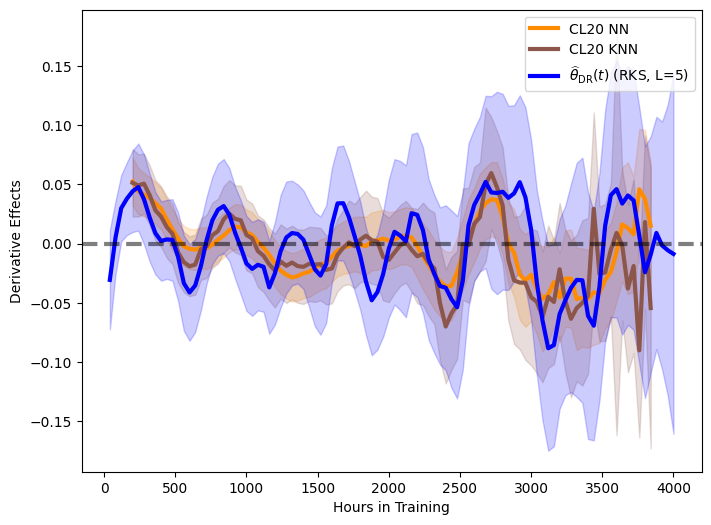

In [7]:
cor_fac = np.std(Y) / np.std(T)
t_list_new = np.arange(40, 4001, 40)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,6))
ml_list = ['nn', 'knn']
col_lst = {'nn': 'darkorange', 'knn': 'tab:brown'}
name_lst = {'nn': 'NN', 'knn': 'KNN'}
for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5_hstar.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 '+str(name_lst[ml]), color=col_lst[ml])
    plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                     dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                     alpha=.2, color=col_lst[ml])

# plt.plot(t_list_new, theta_ra5*cor_fac, color='red', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{RA}}(t)$ (L=5)')    
# plt.plot(t_list_new, theta_ra1*cor_fac, color='purple', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{RA}}(t)$ (L=1)')

# plt.plot(t_list_new, theta_kde_dr5*cor_fac, color='green', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE, L=5)')
# plt.fill_between(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='green', alpha=.2)

plt.plot(t_list_new, theta_dr5*cor_fac, color='blue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=5)')
plt.fill_between(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='blue', alpha=.2)

# plt.plot(t_list_new, theta_dr1*cor_fac, color='darkgreen', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=1)')
# plt.fill_between(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), color='darkgreen', alpha=.2)

plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
plt.xlabel('Hours in Training')
plt.ylabel('Derivative Effects')
plt.legend()
plt.show()

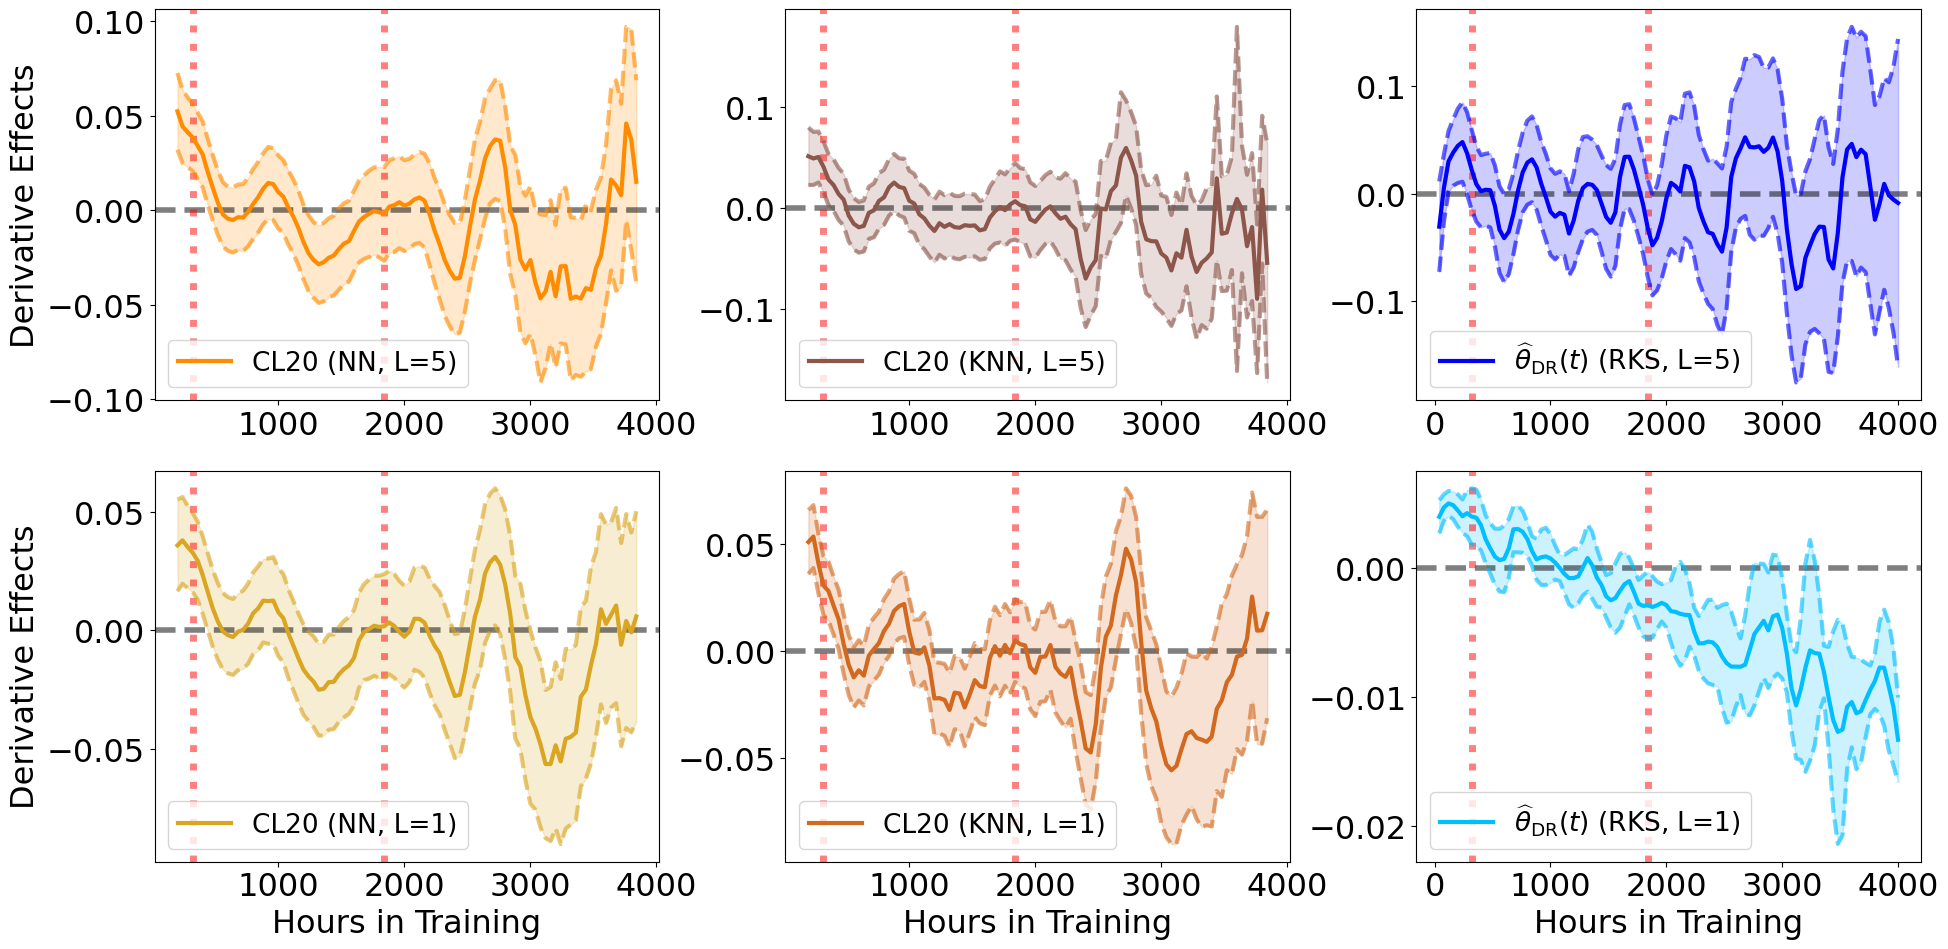

In [8]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_nn_c3_L5_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (NN, L=5)', color='darkorange')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='darkorange', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='darkorange', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='darkorange')
plt.ylabel('Derivative Effects')
plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 2)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_knn_c3_L5_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (KNN, L=5)', color='tab:brown')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='tab:brown', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='tab:brown', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='tab:brown')
plt.legend(loc='lower left', fontsize=19)


# plt.subplot(2, 4, 3)
# plt.plot(t_list_new, theta_kde_dr5*cor_fac, color='green', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE, L=5)')
# plt.plot(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.plot(t_list_new, theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.fill_between(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='green', alpha=.2)
# plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
# plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 3)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.plot(t_list_new, theta_dr5*cor_fac, color='blue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=5)')
plt.plot(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='blue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.plot(t_list_new, theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='blue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.fill_between(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='blue', alpha=.2)
plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 4)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_nn_c3_L1_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (NN, L=1)', color='goldenrod')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='goldenrod', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='goldenrod', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='goldenrod')
plt.xlabel('Hours in Training')
plt.ylabel('Derivative Effects')
plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 5)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_knn_c3_L1_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (KNN, L=1)', color='chocolate')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='chocolate', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='chocolate', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='chocolate')
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)


# plt.subplot(2, 4, 7)
# plt.plot(t_list_new, theta_kde_dr1*cor_fac, color='green', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE, L=1)')
# plt.plot(t_list_new, theta_kde_dr1*cor_fac - theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.plot(t_list_new, theta_kde_dr1*cor_fac + theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.fill_between(t_list_new, theta_kde_dr1*cor_fac - theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_kde_dr1*cor_fac + theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), color='green', alpha=.2)
# plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
# plt.xlabel('Hours in Training')
# plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 6)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.plot(t_list_new, theta_dr1*cor_fac, color='deepskyblue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=1)')
plt.plot(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='deepskyblue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.plot(t_list_new, theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='deepskyblue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.fill_between(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), color='deepskyblue', alpha=.2)
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.18)
plt.savefig('./Figures/job_corps_app.pdf')

In [9]:
t_list_new[theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975) < 0]

array([1480, 1520, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 2040,
       2160, 2200, 2240, 2280, 2320, 2360, 2400, 2440, 2480, 2520, 2560,
       2600, 2640, 2680, 2720, 2880, 3000, 3040, 3080, 3120, 3160, 3320,
       3360, 3400, 3440, 3480, 3520, 3560, 3600, 3640, 3680, 3720, 3760,
       3800, 3840, 3880, 3920, 3960, 4000])

In [12]:
t_list_new[theta_dr1*cor_fac > 0]

array([  40,   80,  120,  160,  200,  240,  280,  320,  360,  400,  440,
        480,  520,  560,  600,  640,  680,  720,  760,  800,  840,  880,
        920,  960, 1000, 1040, 1280, 1320, 1360])

In [13]:
1720/40

43.0